## Hadamard Random Forest (HRF)

In this tutorial, we will go over the basic usage of HRF and run it on IBM quantum hardware.
Given a $n$-qubit real valued quantum state 
$$
\ket{\psi} = U_{\text{prep.}} |0\rangle^{\otimes n} = \sum_{j=0}^{2^n-1} \psi_j\ket{j},
$$ 
where $U_{\text{prep.}}$ is the unitary corresponding to the state preparation circuit and $\psi_j=\text{sgn}(\psi_j)\cdot|\psi_j| \in \mathbb{R}$. The HRF method efficiently reconstructs the corresponding state vector by sampling $n+1$ circuits. $n$ circuits each attached with one Hadamard gate at the end to superpose the amplitudes and $1$ for amplitudes $|\psi_j|$.

Applying a Hadamard gate on the $(n-k-1)$-th qubit (ordering from top to down side of the quantum circuit) and sampling the output leads to a new amplitude vector $\ket{\psi^k}$, where the amplitudes $\psi^k_{j}$ and $ \psi^k_{j+2^k}$ contain the superposition of original amplitudes as
$$
\psi^k_{j, j+2^k} = \frac{1}{\sqrt{2}}\left(\psi_j \pm \psi_{j+2^k}\right).
$$

Then, one can determine the relative signs between two amplitudes $\textnormal{sgn}_{j,j+2^k} = \textnormal{sign}(\psi_j \psi_{j+2^k})$ by querying the ancillary sampling results $\{|\psi^k_j|^2\}_{k=0}^{n-1}$ 
$$
\textnormal{sgn}_{j,j+2^k} = \textnormal{sgn} {\bigg[}\underbrace{2|\psi^k_j|^2}_{\text{new prob.}} - \underbrace{|\psi_j|^2 - |\psi_{j+2^k}|^2}_\text{original prob.}{\bigg]}.
$$

### Setup the hardware

In [11]:
%%capture
from qiskit_ibm_runtime import QiskitRuntimeService

# Get a real backend from the runtime service
# service = QiskitRuntimeService('YOUR_API_TOKEN')
service = QiskitRuntimeService(channel="ibm_quantum", 
                               token="eff90e8bee70d824d8e6c145072c95ec9ba28369fd0c8aa5b192380f5c7ffc207f64bab13f2ae8897269ecdfa88b1f288c4e58c57bdcf86ed8bd500257170657", 
                               instance="ibm-q-ornl/ornl/csc509")

device = service.backend('ibm_marrakesh')

### Circuit construction $U_{\text{prep.}}$

In this tutorial, we will use the `RealAmplitudes` ansatz that consists of layers of $R_y$ rotation gates and adjacent CNOT gates.

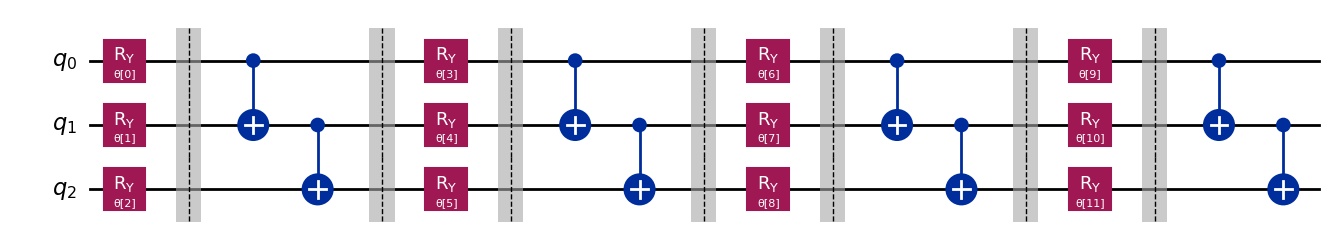

In [12]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 3
num_layers = 4
ansatz = RealAmplitudes(num_qubits, entanglement='pairwise', reps=num_layers, insert_barriers=True, skip_final_rotation_layer=True)
ansatz.decompose().draw("mpl", fold=-1)

### Generate $n+1$ circuits

Here, we need to transpile the circuit into hardware level instructions.

In [13]:
import hadamard_random_forest as hrf

list_circuits = hrf.get_circuits_hardware(num_qubits, ansatz, device)

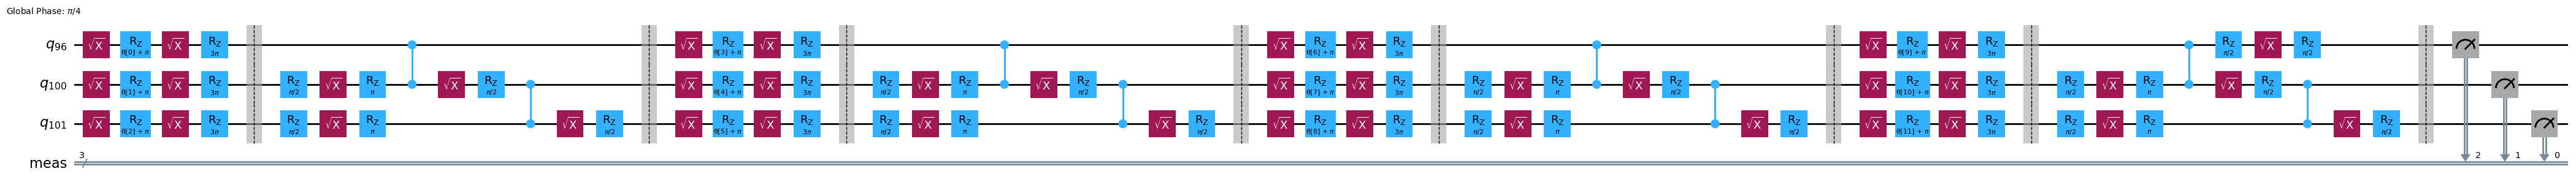

In [14]:
list_circuits[1].reverse_bits().draw("mpl", idle_wires=False, fold=-1)

### Collect sampling results

Collect the ancillary sampling results $\{|\psi^k_j|^2\}_{k=0}^{n-1}$ and amplitudes $\{|\psi_j|^2\}$.

In [15]:
import dill as pickle

# Load pre-generated parameters
with open('params.pkl', 'rb') as f:
    loaded_param = pickle.load(f)

In [16]:
# Set number of experiment shots
shots = 10000

# Set parameters
params = loaded_param['parameter'][(num_qubits, num_layers)][0]  # contains 5 groups of parameters

# Collect samples
samples, raw_samples, ibmq_job_id, qtime = hrf.get_samples_hardware(num_qubits, shots, list_circuits, params, device, error_mitigation=True)

The `get_samples_hardware()` function will return error mitigated samples and raw samples along with `JOB_ID` to retrive hardware results from IBM cloud. `qtime` is the estimated runtime on quantum hardware.

### Reconstruct the state

Once we have sampled the $n+1$ circuits, we will use `samples[0]` to reconstrcut the amplitudes $|\psi_j|$ and `samples[1],...,samples[n]` to determine the signs of each amplitude $\text{sgn}(\psi_j)$. The sign determination is done thorugh a majority voting among many random decision trees (a random forest). One can use `save_tree=True` to save and visualize the trees, where blue nodes stands for $\text{sgn}(\psi_j)=+1$ and orange nodes stands for $\text{sgn}(\psi_j)=-1$. 

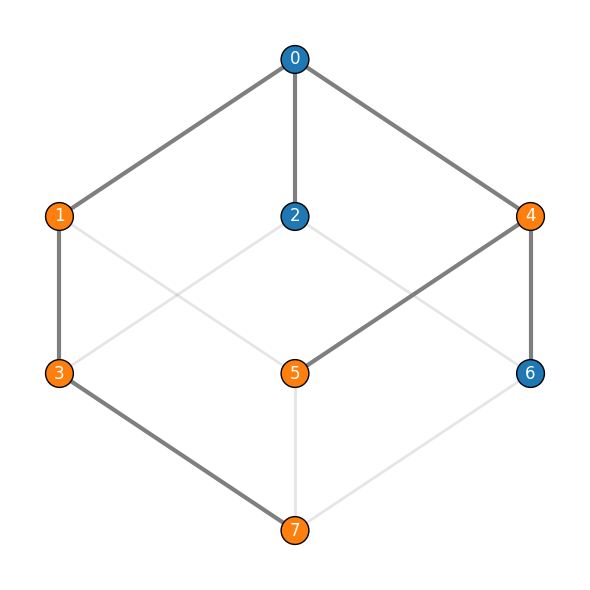

In [17]:
# Set number of decision trees for majority voting
num_trees = 11

# Fix random seed
hrf.fix_random_seed(999)

# Reconstruct the satatevector
statevector_approx = hrf.get_statevector(num_qubits, num_trees, samples, save_tree=True, show_tree=True)

In [18]:
from qiskit.quantum_info import Statevector, state_fidelity

# Evaluate circuit and recover the exact statevector
ansatz.assign_parameters(params, inplace=True)
statevector = Statevector(ansatz)

In [19]:
import numpy as np
    
fid = state_fidelity(statevector_approx, statevector)
print("HRF Fidelity (hardware):", fid)
print("Fidelity Upper Bound (no sign errors):", state_fidelity(np.abs(statevector_approx), np.abs(statevector)))

HRF Fidelity (hardware): 0.9972349412460401
Fidelity Upper Bound (no sign errors): 0.9972349412460401


---

## Software info

In [20]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import mthree

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Mthree error mitigation: {mthree.__version__}')

Qiskit: 2.0.0
Qiskit Aer: 0.17.0
Qiskit IBM Runtime: 0.38.0
Mthree error mitigation: 3.0.0
